In [17]:
%pylab inline
import gzip
import csv

Populating the interactive namespace from numpy and matplotlib
ERROR! Session/line number was not unique in database. History logging moved to new session 200


In [18]:
class AsianOptionSimulation:
    def __init__(self, name, strike, rf_rate, ex_time):
        def read_original_file(file_name):
            with open(file_name) as f:
                csv_raw = list(csv.reader(f))
                data = [row[4] for row in csv_raw][1:]
                initial_date = csv_raw[-1][0]
                final_date = csv_raw[1][0]
                prices = map(float, data)[::-1]
                return prices, initial_date, final_date

        def read_simulation_file(file_name):
            with gzip.open(file_name) as f:
                return [[float(x) for x in l.split(',')] for l in f.readlines()]

        def discount(r, T):
            return ((1.0 + r) ** (T / 360.0))

        def H(path, K):
            return max(0.0, mean(path) - self.K)

        def payoff(H, discount):
            return H / discount
        
        def pricing_error(H, discount):
            N = float(len(H))
            sqSum = 0.0
            sumSq = 0.0
            for h in H:
                sqSum += h ** 2
                sumSq += h
            sqSum /= N
            sumSq /= N
            sumSq = sumSq ** 2
            return sqrt(sqSum - sumSq) / (discount * sqrt(N - 1))

        # Constants
        self.name = name                       # Name of the company
        self.K = float(strike)                 # Strike price
        self.r = float(rf_rate)                # Risk free rate
        self.T = float(ex_time)                # Expired days
        # Read data files
        self.original_data, self.initial_date, self.final_date = read_original_file('../data/historical/' + name + '.csv')
        self.simulation_data = read_simulation_file('../data/output/' + name + '.gz')
        # Gather statistics
        self.discount = discount(self.r, self.T)
        self.payoff_original = payoff(H(self.original_data, self.K), self.discount)
        self.payoffs_h = map(lambda path: H(path, self.K), self.simulation_data)
        self.pricing_error = pricing_error(self.payoffs_h, self.discount)
        self.payoffs_simulation = map(lambda path: payoff(path, self.discount), self.payoffs_h)
        self.payoff_simulation = mean(self.payoffs_simulation)
        self.simulated_final_price = mean(map(lambda path: path[-1], self.simulation_data))
        self.final_price_relative_error = 100 * abs((self.original_data[-1] - self.simulated_final_price) / self.original_data[-1])
        self.payoff_relative_error = 100 * abs((self.payoff_original - self.payoff_simulation) / (self.payoff_original+0.001))
    
    def PrintInfo(self):
        print 'Company:', self.name
        print '------------------------'

        print 'Parameters:'
        print '\tInitial date:', self.initial_date
        print '\tFinal date:', self.final_date
        print '\tStrike price:', self.K
        print '\tRisk free rate:', self.r
        print '\tExpired days:', self.T

        print 'Statistics:'
        print '\tInitial price:', self.original_data[0]
        print '\t# of measurements in the original data:', len(self.original_data)
        print '\t# of measurements in the simulation:', len(self.simulation_data[0])
        print '\t# of simulated paths:', len(self.simulation_data)
        print '\tPricing error:', self.pricing_error
        print '\tOriginal final price:', self.original_data[-1]
        print '\tSimulated final price:', self.simulated_final_price
        print '\tFinal price relative error:', self.final_price_relative_error, '%'
        print '\tPayoff original:', self.payoff_original
        print '\tPayoff simulation:', self.payoff_simulation
        print '\tPayoff relative error:', self.payoff_relative_error, '%'

        print 'Graphs:'
        _, figs = subplots(2, 2, figsize = (20, 15))
        self.PlotPathsSimulation(fig = figs[0, 0])
        self.ComparePaths(fig = figs[0, 1])
        self.HistEndpointsSimulation(fig = figs[1, 0])
        self.HistPayoffsSimulation(fig = figs[1, 1])

        print
        print
        
    def PlotPathsSimulation(self, fig, sample = 0.1):
        for i in xrange(len(self.simulation_data)):
            if rand() <= sample:
                fig.plot(self.simulation_data[i])
        fig.set_title('Simulated stock price (' + self.name + '), from ' + self.initial_date + ' to ' + self.final_date)
    
    def ComparePaths(self, fig):
        ratio = float(len(self.simulation_data[0])) / float(len(self.original_data))
        x_original = [i * ratio for i in xrange(len(self.original_data))]
        mean_path = sum(self.simulation_data, axis = 0) / float(len(self.simulation_data))
        x_simulation = [i for i in xrange(len(mean_path))]
        maxY = max(self.original_data)
        for i in xrange(3):
            sample = self.simulation_data[randint(0, len(self.simulation_data) - 1)]
            sample = [sample[i] for i in arange(0, len(sample), 25)]
            x_sample = [i * 25 for i in xrange(len(sample))]
            fig.plot(x_sample, sample, label = 'Simulated (sample #' + str(i+1) + ')', linewidth = 1.0)
            maxY = max(maxY, max(sample))
        fig.plot(x_simulation, mean_path, label = 'Simulated (mean)', linewidth = 2.0)
        fig.plot(x_original, self.original_data, label = 'Original', linewidth = 2.5)
        fig.set_title('Original vs simulated stock prices, from ' + self.initial_date + ' to ' + self.final_date)
        fig.legend(loc = 'lower right')
        fig.set_ylim((0, 1.25 * maxY))
    
    def HistEndpointsSimulation(self, fig, nbins = 50):
        endpoints = [self.simulation_data[i][-1] for i in xrange(len(self.simulation_data))]

        fig.hist(endpoints, bins = 50)
        fig.set_title('Histogram of the simulated final prices (' + self.name + '), at ' + self.final_date)
    
    def HistPayoffsSimulation(self, fig, nbins = 50):
        fig.hist(self.payoffs_simulation, bins = 50)
        fig.set_title('Histogram of the simulated payoffs (' + self.name + '), at ' + self.final_date)

In [19]:
# Constants
rf_rate = 0.03
ex_time = 20.0

Company: Baidu
------------------------
Parameters:
	Initial date: 2015-03-27
	Final date: 2016-06-03
	Strike price: 150.0
	Risk free rate: 0.03
	Expired days: 20.0
Statistics:
	Initial price: 207.330002
	# of measurements in the original data: 300
	# of measurements in the simulation: 3000
	# of simulated paths: 640
	Pricing error: 0.164379132885
	Original final price: 173.740005
	Simulated final price: 202.049823594
	Final price relative error: 16.2943581093 %
	Payoff original: 31.1738657334
	Payoff simulation: 53.5700348157
	Payoff relative error: 71.8404668486 %
Graphs:




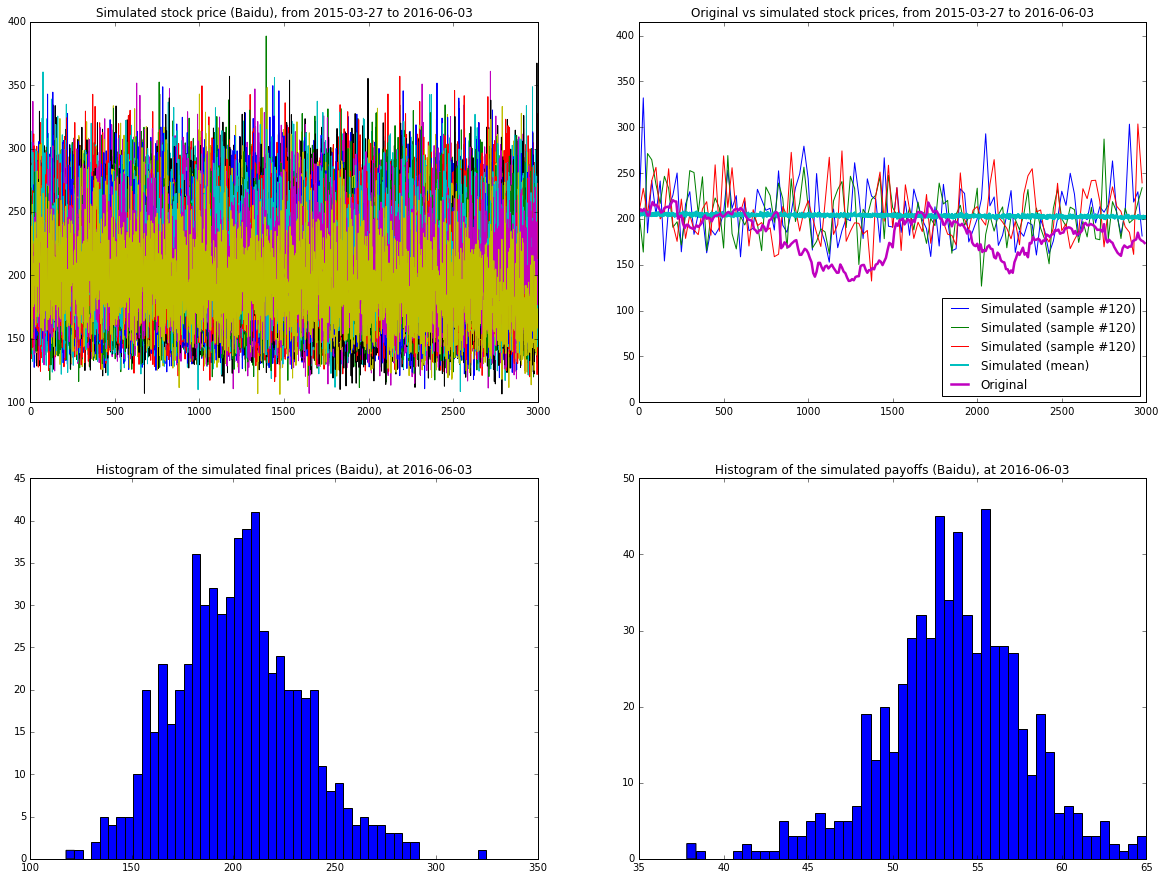

In [20]:
# Baidu
baidu = AsianOptionSimulation('Baidu',
                              strike = 150.0,
                              rf_rate = rf_rate,
                              ex_time = ex_time)
baidu.PrintInfo()

Company: Facebook
------------------------
Parameters:
	Initial date: 2015-03-27
	Final date: 2016-06-03
	Strike price: 70.0
	Risk free rate: 0.03
	Expired days: 20.0
Statistics:
	Initial price: 83.300003
	# of measurements in the original data: 300
	# of measurements in the simulation: 3000
	# of simulated paths: 640
	Pricing error: 0.0279573661512
	Original final price: 118.470001
	Simulated final price: 83.1476023437
	Final price relative error: 29.8154793265 %
	Payoff original: 28.1919996844
	Payoff simulation: 13.2767379267
	Payoff relative error: 52.9041319642 %
Graphs:




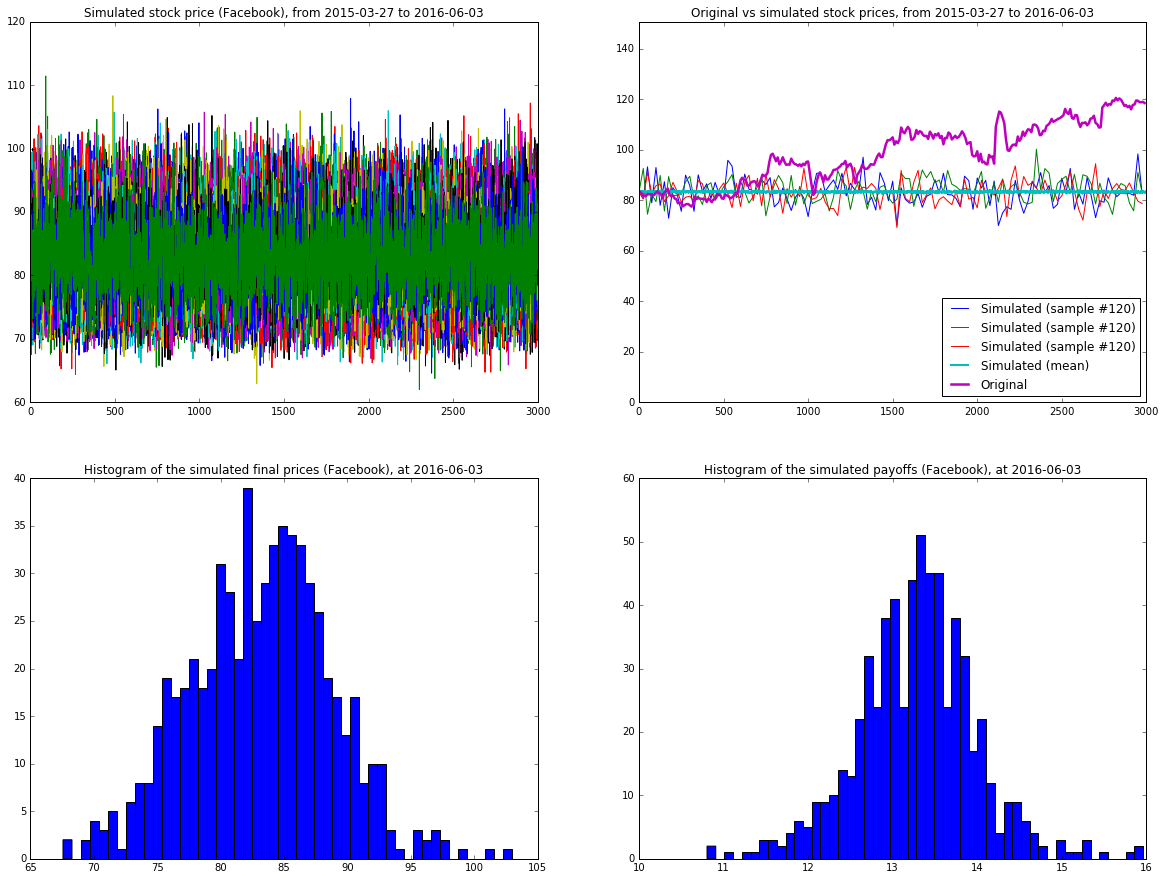

In [21]:
# Facebook
facebook = AsianOptionSimulation('Facebook',
                                 strike = 70.0,
                                 rf_rate = rf_rate,
                                 ex_time = ex_time)
facebook.PrintInfo()

Company: Yandex
------------------------
Parameters:
	Initial date: 2015-03-27
	Final date: 2016-06-03
	Strike price: 15.0
	Risk free rate: 0.03
	Expired days: 20.0
Statistics:
	Initial price: 15.45
	# of measurements in the original data: 300
	# of measurements in the simulation: 3000
	# of simulated paths: 640
	Pricing error: 0.00950090670382
	Original final price: 20.889999
	Simulated final price: 14.8843921875
	Final price relative error: 28.7487175682 %
	Payoff original: 0.52463776201
	Payoff simulation: 0.200012743833
	Payoff relative error: 61.7583137359 %
Graphs:




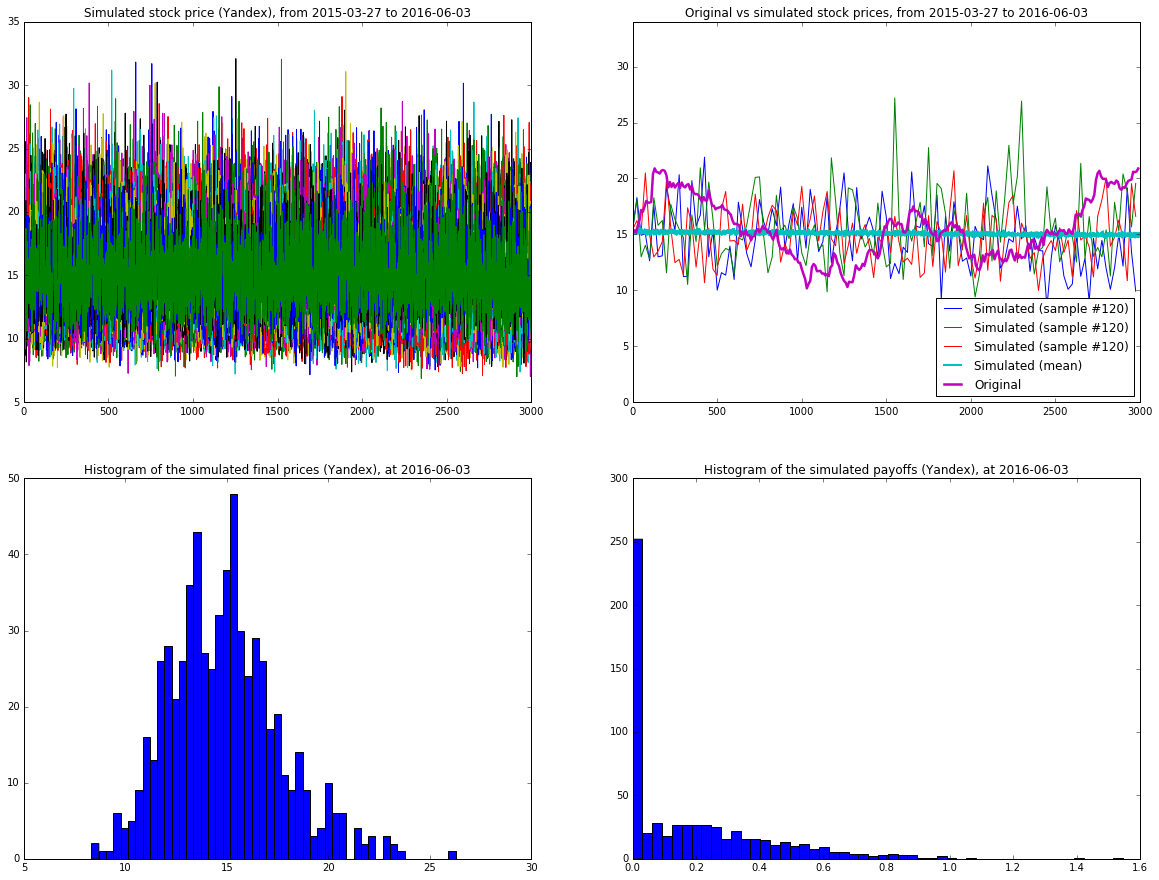

In [22]:
# Yandex
yandex = AsianOptionSimulation('Yandex',
                               strike = 15.0,
                               rf_rate = rf_rate,
                               ex_time = ex_time)
yandex.PrintInfo()